# Notebook - Segmentation of car parts using UNet variants
This notebook will show how we have trained our various models used in our report, it will also recreate the results from the report and poster. To make the notebook as easy-readable as possible we will not have all there required code in here, but it can be found in the various folders. It should be noted that none of our models were actually trained in this notebook, as we trained everything on DTU's High Performance Cluster (HPC) to speed up the process. 

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torchvision.transforms import *
from torchmetrics.functional import iou, dice_score, accuracy
import matplotlib.pyplot as plt

# Data prep
We got the data from Deloitte as 5211 .npy files, which contained GAN-generated images, Opel Astra and Clio 5 Door images modelled and rotated in CAD with random backgrounds, real primary images and augmented versions of the primary images. Each image also had a corresponding mask. We first normalized the images with respect to the ImageNet mean and standard deviation, as can be seen in the ***./utils/data_prep/data_filter.py*** file. Afterwards we split the images up into train, test and validation folders. We got 30 images which we were told to use for test, so we first took those into the test folder and then removed them and all of the augmented versions of them from the other folders. We then took the rest of the images and split into a 80/20 train/validation split, such that each of the different image types are split 80/20 between train/val. The code to do the split can be seen in the ***./utils/data_prep/train_test_val.py*** file.

# Training
We will here show how we trained the various models to get our results showed in the poster/report. All of the models were trained with this same "loop", but the parameters such as grayscaling, backbone, unet version etc. changes.  

Initially when figuring out how to approach the project we tried programming our own UNet, and tried putting in a backbone. This was to figure out how the UNet actually looked and worked like in code, and to see how a backbone actually is put into the encoder part of a segmentation model. After we figured that out we switched over to use a library, $https://github.com/qubvel/segmentation\_models.pytorch$, which has a variety of segmentation models and backbones to choose from out-of-the-box. This allowed us to get more advanced models and backbones working quickly. The original UNet code can be seen in the $./unet$ folder in the root of the project, but we have not used it since the start of the project. The results in the report and poster only uses the models from the library.


In [2]:
# We load utils from the root of our project:
from utils.dataloader.car_dataset import CarDataset
from utils.background_rem.bg_manager import BgManager
from utils.background_rem.bg_remover import init_bg_remover

We define the paths of the validation and training data:

In [3]:
validation_path = "E:/dtu/2sem/deeplearn/project/data_folder_2/validation/"
train_path = "E:/dtu/2sem/deeplearn/project/data_folder_2/train/"

We rely heavily on augmentation in this project as we have very few high quality images. We use pytorch transforms for image augmentation:

In [4]:
transform = transforms.Compose([
        RandomHorizontalFlip(p=0.5),
        RandomPerspective(distortion_scale=0.3, p=0.4),
        transforms.RandomApply(transforms=[
            RandomResizedCrop(size=(256, 256), scale=(0.40, 1.0)),
        ], p=0.4),
        transforms.RandomApply(transforms=[
            GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        ], p=0.2),
        transforms.RandomErasing(p=0.2), 
        transforms.RandomRotation(degrees=(-10, 10)), 
    ])

We define the training and validation set with our custom torch dataset, named CarDataset. The code for CarDataset can be seen in ***./utils/dataloader/car\_dataset.py*** We programmed the dataset such that we can specify how much we want of the different types of images. So below for training we only use 300 of the opel images, 300 of the clio door images and 8 times of the primary images. For validation we only validate on the primary images, as we want to know the results on real car images:

In [5]:
# Trained with this data:
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           augmentation=transform)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
valid_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=0)

# We define the model: 
model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e', # We use the ResNeSt 200 backbone
    encoder_weights='imagenet', # The backbone is trained on imagenet
    classes=9, # We have 9 classes
    activation='softmax2d', # The last activation is a softmax
    in_channels=3
)

We define the training loop, but do not actually run the code here as everything was ran on the HPC:

In [ ]:
def save_logs(train_log, valid_log):
    np.save("./train_log.npy", train_log)
    np.save("./valid_log.npy", valid_log)
    
DEVICE = 'cuda'
    
criterion = smp.utils.losses.DiceLoss() # The SMP library also contains various loss functions

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

model.to(DEVICE)

min_score = 1 

train_logs = []
valid_logs = []

EPOCHS = 80
for i in range(0, EPOCHS):
    print('\nEpoch: {}'.format(i))
    train_log = []
    model.train()
    for image, mask in train_loader:
        image = image.to(DEVICE)
        mask = mask.to(DEVICE)
        
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, mask)
        loss.backward()

        optimizer.step()

        train_log.append(loss.item())
    
    train_mean = np.mean(train_log)
    print("Training loss: ",train_mean)
    train_logs.append(train_mean)

    valid_log = []
    model.eval()
    for image, mask in valid_loader:
        image = image.to(DEVICE)
        mask = mask.to(DEVICE)   

        pred = model(image)

        loss = criterion(pred,mask)
        valid_log.append(loss.item())

    valid_mean = np.mean(valid_log)
    print("Validation loss: ",valid_mean)
    valid_logs.append(valid_mean)

    if (min_score > valid_mean):
        min_score = valid_mean
        torch.save(model.state_dict(), 'best_model_dict.pth')
        print("Model saved!")
    if i == EPOCHS/2:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('---- Decreased Learning Rate to 1e-5! ----')

save_logs(train_logs, valid_logs)

So we run it for 80 epochs, and in each epoch we save the mean of the training and validation loss in an array. During training we keep saving the model with the lowest validation loss and after we have been through half of the epchs we lower the learning rate. Finally we save validation and training array as numpy files so we can load them later to make a performance graph. 

The performance graph of our best models (which will be seen in the next section) training and validation loss can be seen below:

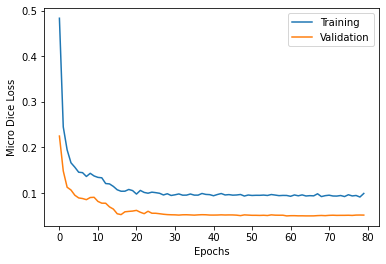

In [6]:
train_log = np.load('E:/GitHub/02456-deep-learning-segmentation/models/train_log.npy')
valid_log = np.load('E:/GitHub/02456-deep-learning-segmentation/models/valid_log.npy')

plt.clf()
plt.plot(train_log, label="Training")
plt.plot(valid_log, label="Validation")
plt.xlabel('Epochs')
plt.ylabel('Micro Dice Loss')
plt.legend()
plt.show()

It can indeed be noted that the network converges extremely fast, thanks to transfer learning. 

# Recreating the results from the poster/report
Everytime we trained a model on the HPC we saved the best model (the one with the lowest validation loss during training). We then took these saved models, ran them on the test set and looked at the predicted pictures. In this section we recreate the performance on the test set on the various models.  

We define a method which predicts the mask on each of our test images and returns the various metrics:

In [17]:
from torchmetrics.functional import dice_score, accuracy

def calc_test_metrics(model, test_dataloader):
    
    dice_scores_macro = []
    accuracy_macro =  []
    
    for i in test_dataloader:
        img, mask = i
        pr_mask = model.predict(img) # Predict the mask according to the image
        pred = pr_mask[0]
        truth = mask[0]
        
        # We go from [9,256,256] -> [256,256] - e.i. onehot encode to integer encode
        pred_label = torch.argmax(pred, dim=0)
        truth_label = torch.argmax(truth, dim=0)
        
        truth_flat = truth_label.view(-1) # go from [256,256] -> [256*256]
        pred_flat = torch.flatten(pred, start_dim=1) # go from [9,256,256] -> [9,256*256]
        pred_flat = pred_flat.permute(1,0) # go from [9,256*256] -> [256*256,9]]

        # calculate dice score macro with only present channels
        data_dicescore = dice_score(pred_flat, truth_flat, reduction='none', no_fg_score=-1)
        masked_dices = torch.masked_select(data_dicescore,data_dicescore.not_equal(-1))
        dice_scores_macro.append(masked_dices.mean())
        
        # calculate accuracy
        acc = accuracy(pred_label, truth_label, average='macro', num_classes=9)
        accuracy_macro.append(acc)

    return np.mean(dice_scores_macro), np.mean(accuracy_macro)    

In [8]:
models_base_path = 'E:/GitHub/02456-deep-learning-segmentation/models/'
test_path = "E:/dtu/2sem/deeplearn/project/data_folder_2/test/"
test_dataset = CarDataset(test_path, test=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

The results from the UNet model with a ResNet34 backbone: 

In [9]:
# Trained with this data:
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           augmentation=transform)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1)

# We define the actual model: 
unet_r34_model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=9,
    activation='softmax2d',
    in_channels=3
)

# We load in the saved dict of the model from the HPC:
model_path = models_base_path + 'unet_34resnet_8prim_300dooropel.pth'
unet_r34_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# We use the model to measure performance on the test data: 
unet_r34_model.eval()
dice, accuracy = calc_test_metrics(unet_r34_model, test_dataloader)
print("Dice Score: ", dice)
print("Accuracy: ", accuracy)

Dice Score:  0.7023359
Accuracy:  0.7148064


The results from the UNet++ model with a ResNet34 backbone: 

In [11]:
# Trained with this data:
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           augmentation=transform)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1)

# We define the actual model: 
unetpp_r34_model = smp.UnetPlusPlus(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=9,
    activation='softmax2d',
    in_channels=3
)


# We load in the saved dict of the model from the HPC:
model_path = models_base_path + 'unetpp_34resnet_8prim_300dooropel.pth'
unetpp_r34_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# We use the model to measure performance on the test data: 
unetpp_r34_model.eval()
dice, accuracy = calc_test_metrics(unetpp_r34_model, test_dataloader)
print("Dice Score: ", dice)
print("Accuracy: ", accuracy)

Dice Score:  0.71114963
Accuracy:  0.72777694


The results from the UNet++ model with a ResNeSt200 backbone and background removal: 

In [14]:
# Trained with this data: 
predictor = init_bg_remover()
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           bg_manager = BgManager(), predictor=predictor, augmentation=transform)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1)

# We define the actual model: 
unetpp_r200_bgrem_model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e',
    encoder_weights='imagenet',
    classes=9,
    activation='softmax2d',
    in_channels=3
)

# We load in the saved dict of the model from the HPC:
model_path = models_base_path + '/unetpp_200resnest_8prim_300dooropel_bgrem.pth'
unetpp_r200_bgrem_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# We use the model to measure performance on the test data:
unetpp_r200_bgrem_model.eval()
dice, accuracy = calc_test_metrics(unetpp_r200_bgrem_model, test_dataloader)
print("Dice Score: ", dice)
print("Accuracy: ", accuracy)

Dice Score:  0.69007856
Accuracy:  0.66921806


The results from the UNet++ model with a ResNeSt200 backbone and grayscaling: 

In [16]:
# Trained with this data:
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           augmentation=transform, grayscale=True)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1, 
                                grayscale=True)

# We define the actual model:  
unetpp_r200_grayscale_model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e',
    encoder_weights='imagenet',
    classes=9,
    activation='softmax2d',
    in_channels=1 # Only one channel her since its grayscale
)


# We load in the saved dict of the model from the HPC:
model_path = models_base_path + 'unetpp_200resnest_8prim_300dooropel_grayscale.pth'
unetpp_r200_grayscale_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# We use the model to measure performance on the test data: 
test_dataloader_grayscale = DataLoader(CarDataset(test_path, test=True, grayscale=True), shuffle=False)
unetpp_r200_grayscale_model.eval()
dice, accuracy = calc_test_metrics(unetpp_r200_grayscale_model, test_dataloader_grayscale)
print("Dice Score: ", dice)
print("Accuracy: ", accuracy)

Dice Score:  0.71854645
Accuracy:  0.7267388


The results from the UNet++ model with a ResNeSt200 backbone: 

In [18]:
# Trained with this data:
train_dataset = CarDataset(train_path, num_gan=0, num_deloitte_aug=0, num_opel=300, num_door=300, num_primary_multiple=8, 
                           augmentation=transform)
validation_dataset = CarDataset(validation_path, num_gan=0, num_deloitte_aug=0, num_opel=0, num_door=0, num_primary_multiple=1)

# The actual model: 
unetpp_r200_model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e',
    encoder_weights='imagenet',
    classes=9,
    activation='softmax2d',
    in_channels=3
)

# We load in the saved dict of the model from the HPC:
model_path = models_base_path + 'unetpp_200resnest_8prim_300dooropel.pth'
unetpp_r200_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# We use the model to measure performance on the test data: 
unetpp_r200_model.eval()
dice, accuracy= calc_test_metrics(unetpp_r200_model, test_dataloader)
print("Dice Score: ", dice)
print("Accuracy: ", accuracy)

Dice Score:  0.73269635
Accuracy:  0.7310807


***unetpp_r200_model*** gives the best results (according to dice score), which is UNet++ with ResNest200 backbone, heavy augmentation, multiple times of the primary data and both some opel and clio door data. All the other models were trained with the exact same parameters given to the CarDataset, except for the grayscaling and background removal models. The only other things that have changed is the model architecture and backbone. This specific data split used for training (Multiple primary data and some opel/door data) is the result after trying various combinations, where it was finally found out to be the best.

We now use this model to do the predictions shown in the report/poster. 

We define a method to visualize the car image, the ground truth mask, and the predicton: 

In [92]:
def visualize(car_img=None, mask=None, predicted=None):
    n = 3
    plt.figure(figsize=(16, 5))
    plt.subplot(1, n, 1)
    plt.imshow(np.dstack(car_img))
    plt.title("Actual image")
    plt.subplot(1, n, 2)
    plt.imshow(mask)
    plt.title("True mask")
    plt.subplot(1, n, 3)
    plt.imshow(predicted)
    plt.title("Model prediction")
    plt.show()

Another method to prep for visualization: 

In [93]:
def prep_and_viz(data, model):
    img, mask = data

    mask = mask.permute(1,2,0)
    mask = torch.argmax(mask, dim=2)

    pred = model.predict(img.unsqueeze(0))
    
    pred = pred.squeeze().cpu().permute(1, 2, 0)
    pred = torch.argmax(pred, dim=2)

    visualize(img,mask,pred)

We predict and plot the same models as we did in the poster/report:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


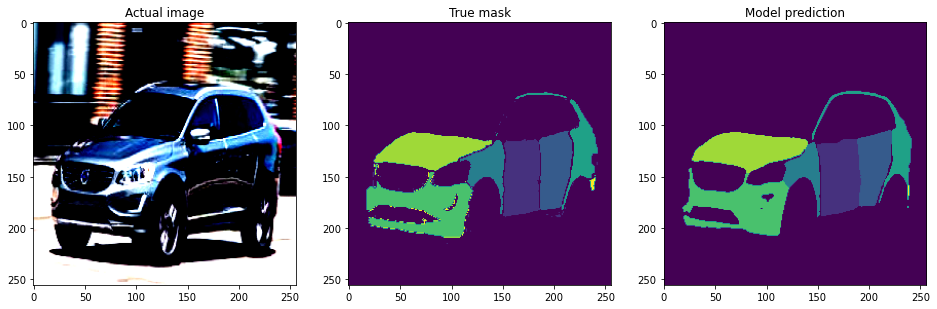

In [94]:
prep_and_viz(test_dataset[4], unetpp_r200_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


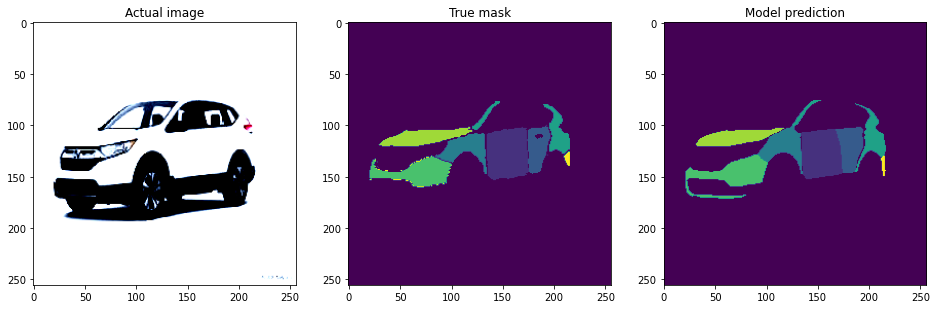

In [95]:
prep_and_viz(test_dataset[14], unetpp_r200_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


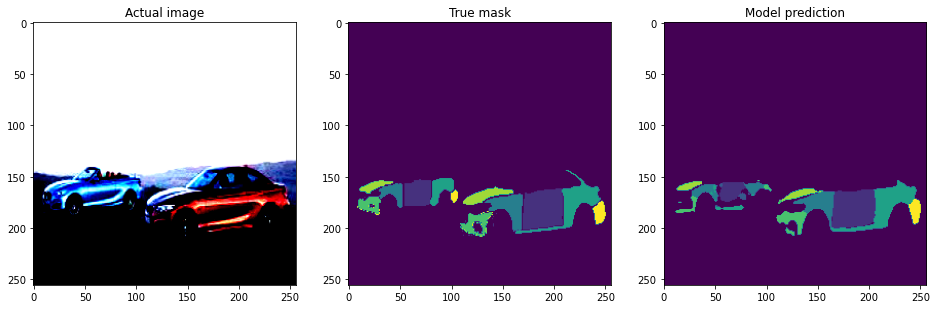

In [96]:
prep_and_viz(test_dataset[17], unetpp_r200_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


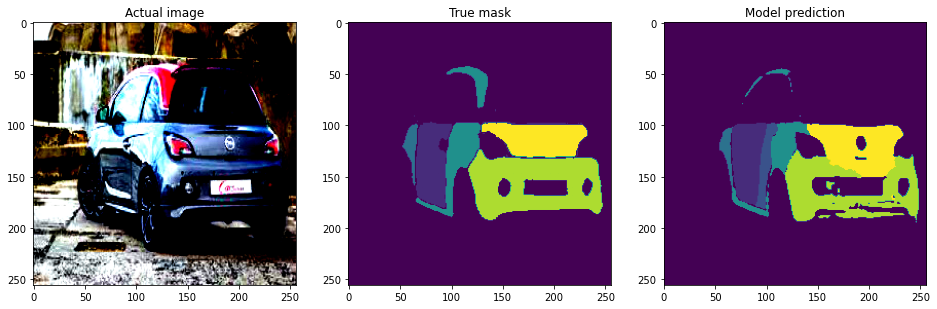

In [97]:
prep_and_viz(test_dataset[10], unetpp_r200_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


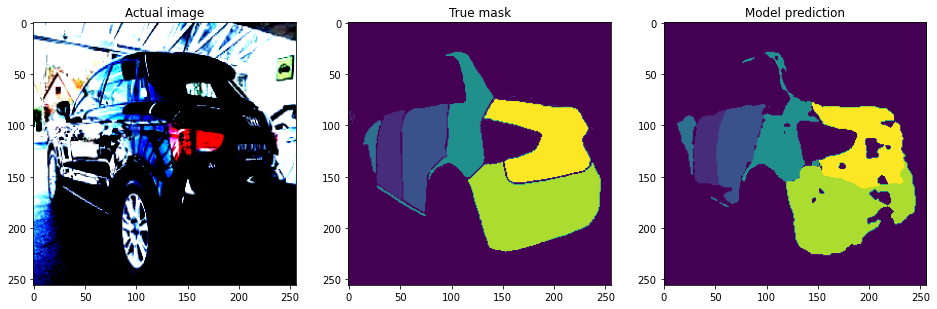

In [98]:
prep_and_viz(test_dataset[9], unetpp_r200_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


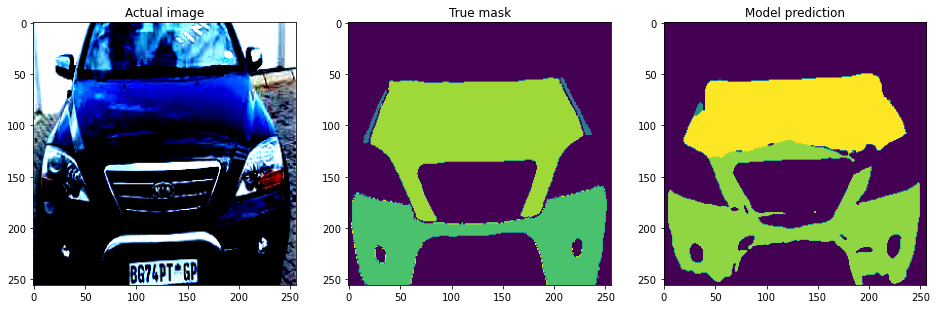

In [99]:
prep_and_viz(test_dataset[0], unetpp_r200_model)

In the poster and report we also showed how our model treated images found on Google. Here we will show how we did that: 

In [100]:
from PIL import Image
from torchvision.transforms import *
import requests

def visualize2(car_img=None, mask=None):
    n = 2
    plt.figure(figsize=(11, 5))
    plt.subplot(1, n, 1)
    plt.imshow(car_img)
    plt.title("Image")
    plt.subplot(1, n, 2)
    plt.imshow(mask)
    plt.title("Predicted mask")
    plt.show()

    
def predict_mask_img(image_path,  model):
    pil_img = Image.open(image_path)
    pil_img = pil_img.resize((256,256))
    np_img = np.array(pil_img)[...,:3]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    img = transform(np_img)

    pred = model.predict(img[None,:])
    pred = pred[0]
    pred_int = torch.argmax(pred,dim=0)

    visualize2(car_img=np_img, mask=pred_int)

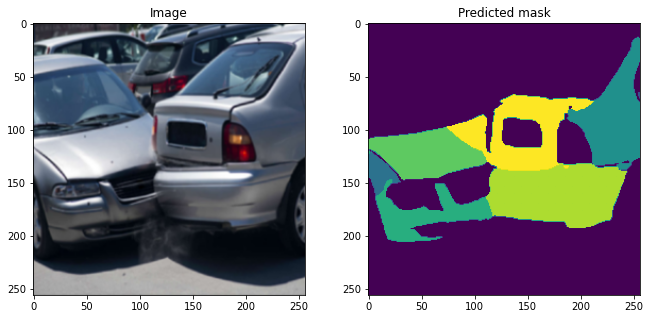

In [101]:
predict_mask_img("E:/carcrash.png",unetpp_r200_model)

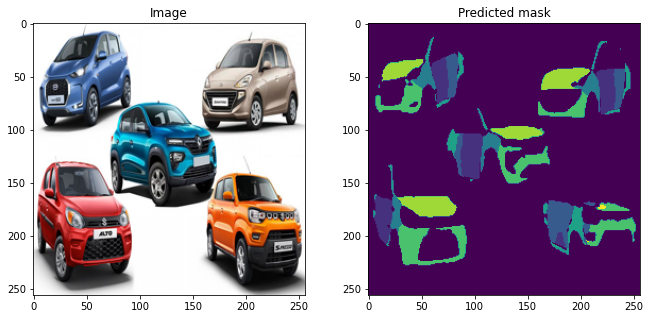

In [102]:
predict_mask_img("E:/multiplecars.jpg",unetpp_r200_model)